In [1]:
import argparse
import copy
import itertools
import warnings
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    f_classif,
)
from sklearn.metrics import (
    auc,
    matthews_corrcoef,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize
from sklearn.svm import SVC

# from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from xgboost import XGBClassifier

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)



# OvO and OvR prediction function

In [15]:
def split_classes(X, y):
    return {
        (c1, c2): (X[(y == c1) | (y == c2)], y[(y == c1) | (y == c2)])
        for c1, c2 in itertools.combinations(np.unique(y), 2)
    }


def ovo_and_ova_multiclass_auc(X, y, base_clf, p_grid, random_state):
    results = {}
    le = LabelEncoder()
    y = le.fit_transform(y)
    class_names = le.classes_

    # Stratified K-Folds
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    ####################
    # One-vs-Rest Classification
    ####################
    print("Performing One vs Rest classification")
    ovr_clf = GridSearchCV(
        estimator=OneVsRestClassifier(base_clf),
        param_grid=p_grid,
        cv=inner_cv,
        scoring="roc_auc_ovr",
    )
    y_score = cross_val_predict(ovr_clf, X, y, cv=outer_cv, method="predict_proba")

    # Calculate AUC for each class
    y_bin = LabelBinarizer().fit_transform(y)
    ovr_auc = roc_auc_score(y_bin, y_score, multi_class="ovr", average=None)
    for idx, auc_val in enumerate(ovr_auc):
        print(f"AUC for class '{class_names[idx]}': {auc_val:.4f}")
        results[f"{class_names[idx]} vs Rest - AUC"] = auc_val

    # Calculate precision, recall, F1, and MCC for each class in OvR
    y_pred_ovr = np.argmax(y_score, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred_ovr, average=None
    )
    for idx in range(len(class_names)):
        results[f"{class_names[idx]} vs Rest - Precision"] = precision[idx]
        results[f"{class_names[idx]} vs Rest - Recall"] = recall[idx]
        results[f"{class_names[idx]} vs Rest - F1"] = f1[idx]

        # Calculate MCC for each class in OvR
        mcc = matthews_corrcoef(y, (y_pred_ovr == idx).astype(int))
        results[f"{class_names[idx]} vs Rest - MCC"] = mcc

    # Calculate macro AUC, precision, recall, F1, and MCC for OvR
    macro_ovr_auc = roc_auc_score(y_bin, y_score, multi_class="ovr", average="macro")
    macro_ovr_precision = np.mean(precision)
    macro_ovr_recall = np.mean(recall)
    macro_ovr_f1 = np.mean(f1)
    macro_ovr_mcc = np.mean(
        [
            matthews_corrcoef(y, (y_pred_ovr == idx).astype(int))
            for idx in range(len(class_names))
        ]
    )

    results["OvR Macro AUC"] = macro_ovr_auc
    results["OvR Macro Precision"] = macro_ovr_precision
    results["OvR Macro Recall"] = macro_ovr_recall
    results["OvR Macro F1"] = macro_ovr_f1
    results["OvR Macro MCC"] = macro_ovr_mcc

    print(f"Macro AUC (OvR): {macro_ovr_auc:.4f}")
    print(f"Macro Precision (OvR): {macro_ovr_precision:.4f}")
    print(f"Macro Recall (OvR): {macro_ovr_recall:.4f}")
    print(f"Macro F1 (OvR): {macro_ovr_f1:.4f}")
    print(f"Macro MCC (OvR): {macro_ovr_mcc:.4f}")

    ####################
    # One-vs-One Classification
    ####################
    print("Performing One vs One classification")
    ovo_auc = {}
    ovo_precision = {}
    ovo_recall = {}
    ovo_f1 = {}
    ovo_mcc = {}
    class_pairs = split_classes(X, y)

    for (c1, c2), (X_subset, y_subset) in class_pairs.items():
        ovo_clf = GridSearchCV(
            estimator=base_clf,
            param_grid={k.replace("estimator__", ""): v for k, v in p_grid.items()},
            cv=inner_cv,
            scoring="roc_auc",
        )
        y_score = cross_val_predict(
            ovo_clf, X_subset, y_subset, cv=outer_cv, method="predict_proba"
        )
        y_binary = (y_subset == c2).astype(int)
        fpr, tpr, _ = roc_curve(y_binary, y_score[:, 1])
        auc_val = auc(fpr, tpr)

        # Compute precision, recall, F1, and MCC for each class pair (OvO)
        y_pred_ovo = np.argmax(y_score, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_binary, y_pred_ovo, average="binary"
        )

        # MCC for each class pair (OvO)
        mcc = matthews_corrcoef(y_binary, y_pred_ovo)

        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - AUC"
        ] = auc_val
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - Precision"
        ] = precision
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - Recall"
        ] = recall
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - F1"
        ] = f1
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - MCC"
        ] = mcc

        ovo_auc[(c1, c2)] = auc_val
        ovo_precision[(c1, c2)] = precision
        ovo_recall[(c1, c2)] = recall
        ovo_f1[(c1, c2)] = f1
        ovo_mcc[(c1, c2)] = mcc

    # Calculate macro AUC, precision, recall, F1, and MCC for OvO
    macro_ovo_auc = np.mean(
        list(ovo_auc.values())
    )  # Macro: Average AUC over all class pairs
    macro_ovo_precision = np.mean(list(ovo_precision.values()))
    macro_ovo_recall = np.mean(list(ovo_recall.values()))
    macro_ovo_f1 = np.mean(list(ovo_f1.values()))
    macro_ovo_mcc = np.mean(list(ovo_mcc.values()))

    results["OvO Macro AUC"] = macro_ovo_auc
    results["OvO Macro Precision"] = macro_ovo_precision
    results["OvO Macro Recall"] = macro_ovo_recall
    results["OvO Macro F1"] = macro_ovo_f1
    results["OvO Macro MCC"] = macro_ovo_mcc

    print(f"Macro AUC (OvO): {macro_ovo_auc:.4f}")
    print(f"Macro Precision (OvO): {macro_ovo_precision:.4f}")
    print(f"Macro Recall (OvO): {macro_ovo_recall:.4f}")
    print(f"Macro F1 (OvO): {macro_ovo_f1:.4f}")
    print(f"Macro MCC (OvO): {macro_ovo_mcc:.4f}")

    return results


def repeat_clf(n_seeds, ks, X, y, label, model, sampling_strategy):

    print(ks)
    print(n_seeds)

    # Define sampling strategies
    sampling_strategies = {
        "No Sampling": None,
        "Random OverSampling": RandomOverSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "Random UnderSampling": RandomUnderSampler(random_state=42),
        "NearMiss (v1)": NearMiss(version=1),
        "NearMiss (v2)": NearMiss(version=2),
        "NearMiss (v3)": NearMiss(version=3),
    }

    # If the selected strategy is not in the dictionary, use "No Sampling"
    sampler = sampling_strategies.get(sampling_strategy, None)

    seed_results = {}

    for seed in range(n_seeds):

        ks_results = {}
        for k in ks:

            print(f"CV for seed {seed} and {k} features")

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(random_state=seed)

            # Create a SelectFromModel using the Random Forest Classifier
            selector = SelectFromModel(rf, max_features=k)

            if model == "rf":
                ml_model = rf
                ml_model_grid = {
                    "estimator__classification__n_estimators":[100, 300, 500],  # Number of trees in the forest
                    "estimator__classification__max_depth": [None, 10, 20, 30],  # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # Feature selection strategy
                    "estimator__classification__criterion": ["entropy"],  # Split criterion
                    "estimator__classification__min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
                }
            elif model == "xgb":
                ml_model = XGBClassifier(
                    use_label_encoder=False, eval_metric="logloss", random_state=seed
                )
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500], 
                    "estimator__classification__gamma": [0, 0.1, 0.3], # min loss reduction
                    "estimator__classification__max_depth": [3, 5, 7], 
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1], # step size
                }
            elif model == "etc":
                ml_model = ExtraTreesClassifier(random_state=seed)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],
                    "estimator__classification__max_depth": [None, 10, 20],       # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # features per split
                    "estimator__classification__min_samples_leaf": [1, 2, 4],     # min leaf samples
                    
                }
            elif model == "lgbm":
                ml_model = LGBMClassifier(random_state=seed, verbose=-1)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],  
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1],
                    "estimator__classification__num_leaves": [31, 63, 127],      # leaves per tree
                            
                }

            # If there is a sampler, include it in the pipeline
            steps = []
            if sampler:
                steps.append(("sampling", sampler))
            steps.append(("feature_selection", selector))
            steps.append(("classification", ml_model))

            # Create a pipeline with feature selection, sampling, and classification
            pipeline = Pipeline(steps=steps)

            ###########################

            # Run the classification with the sampling strategy
            results = ovo_and_ova_multiclass_auc(
                X, y, pipeline, ml_model_grid, random_state=seed
            )

            print(results)

            ks_results[k] = {
                "results": results,
                "Label": label,
                "Model": model,
                "Sampling_Strategy": sampling_strategy,
            }


        seed_results[seed] = copy.copy(ks_results)

    return seed_results


def store_results(seed_results, output):

    # Flatten the nested dictionary into a DataFrame
    '''df = pd.DataFrame(
        {
            (outer_key, inner_key): values
            for outer_key, inner_dict in seed_results.items()
            for inner_key, values in inner_dict.items()
        }
    ).T

    # '''
    
    final_results = []
    
    for seed, ks_results in seed_results.items():
        for k, result_info in ks_results.items():
            result = result_info["results"]
            model = result_info["Model"]
            sampling_strategy = result_info["Sampling_Strategy"]
            label=result_info["Label"]
            
            # Collect all relevant information in a list
            final_results.append({
                "Seed": seed,
                "Features (k)": k,
                "Label":label,
                "Model": model,
                "Sampling_Strategy": sampling_strategy,
                **result, 
            })
    df = pd.DataFrame(final_results)

    #Set multi-level index names for clarity
    df.set_index(["Seed", "Features (k)", "Label", "Model", "Sampling_Strategy"], inplace=True)

    df.index.names = ["Seed", "Features (k)","Label","Model","Sampling_Strategy"]
    # Display the DataFrame
    df = df.reset_index()

    df.to_csv(output, mode='a', header=not os.path.exists(output), index=False)

    print(df)


def run_classification(X, y, ks, n_seeds,output, label,model, sampling_strategy):

    # Ensure ks does not exceed the number of columns in X
    max_features = len(X.columns)
    ks = [k for k in ks if k <= max_features]
    if max_features not in ks:
        ks.append(max_features)

    seed_results = repeat_clf(n_seeds, ks, X, y, label,model, sampling_strategy)
    store_results(seed_results, output)




# Test multiclass dataset to evaluate the function

In [12]:
from sklearn.datasets import make_classification
import pandas as pd

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=150,      # Number of samples
    n_features=1000,    # Total number of features
    n_informative=20,   # Number of informative features
    n_redundant=200,    # Number of redundant features
    n_classes=3,        # Number of target classes
    weights=[0.7, 0.2, 0.1],  # Proportion for each class
    random_state=42     # For reproducibility
)

# Convert to DataFrame
X = pd.DataFrame(X)
y = pd.Series(y, name="target")

# Display class distribution
print(y.value_counts())


target
0    105
1     31
2     14
Name: count, dtype: int64


In [17]:
n_seeds = 2
ks = [2]

run_classification(X, y, ks, n_seeds,"benchmark/results/synthetic.csv", "s150_f1000_red200","rf","SMOTE" )


[2, 1000]
2
CV for seed 0 and 2 features
Performing One vs Rest classification
AUC for class '0': 0.7634
AUC for class '1': 0.8229
AUC for class '2': 0.6510
Macro AUC (OvR): 0.7457
Macro Precision (OvR): 0.5523
Macro Recall (OvR): 0.5805
Macro F1 (OvR): 0.5639
Macro MCC (OvR): 0.0228
Performing One vs One classification
Macro AUC (OvO): 0.7627
Macro Precision (OvO): 0.4563
Macro Recall (OvO): 0.5115
Macro F1 (OvO): 0.4810
Macro MCC (OvO): 0.3455
{'0 vs Rest - AUC': np.float64(0.7633862433862434), '1 vs Rest - AUC': np.float64(0.8228517213336948), '2 vs Rest - AUC': np.float64(0.6509978991596639), '0 vs Rest - Precision': np.float64(0.8350515463917526), '0 vs Rest - Recall': np.float64(0.7714285714285715), '0 vs Rest - F1': np.float64(0.801980198019802), '0 vs Rest - MCC': np.float64(-0.36621415144441355), '1 vs Rest - Precision': np.float64(0.5277777777777778), '1 vs Rest - Recall': np.float64(0.6129032258064516), '1 vs Rest - F1': np.float64(0.5671641791044776), '1 vs Rest - MCC': np.

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.8491
Macro Precision (OvO): 0.5303
Macro Recall (OvO): 0.3971
Macro F1 (OvO): 0.4538
Macro MCC (OvO): 0.3866
{'0 vs Rest - AUC': np.float64(0.8414814814814815), '1 vs Rest - AUC': np.float64(0.8950935212794795), '2 vs Rest - AUC': np.float64(0.7022058823529411), '0 vs Rest - Precision': np.float64(0.808), '0 vs Rest - Recall': np.float64(0.9619047619047619), '0 vs Rest - F1': np.float64(0.8782608695652174), '0 vs Rest - MCC': np.float64(-0.5105591764046271), '1 vs Rest - Precision': np.float64(0.76), '1 vs Rest - Recall': np.float64(0.6129032258064516), '1 vs Rest - F1': np.float64(0.6785714285714286), '1 vs Rest - MCC': np.float64(0.5105591764046271), '2 vs Rest - Precision': np.float64(0.0), '2 vs Rest - Recall': np.float64(0.0), '2 vs Rest - F1': np.float64(0.0), '2 vs Rest - MCC': 0.0, 'OvR Macro AUC': np.float64(0.8129269617046341), 'OvR Macro Precision': np.float64(0.5226666666666667), 'OvR Macro Recall': np.float64(0.5249359959037379), 'OvR Macro F1': np.float

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.8906
Macro Precision (OvO): 0.6316
Macro Recall (OvO): 0.3495
Macro F1 (OvO): 0.4489
Macro MCC (OvO): 0.4264
{'0 vs Rest - AUC': np.float64(0.8548148148148148), '1 vs Rest - AUC': np.float64(0.9005150447275685), '2 vs Rest - AUC': np.float64(0.8539915966386555), '0 vs Rest - Precision': np.float64(0.8095238095238095), '0 vs Rest - Recall': np.float64(0.9714285714285714), '0 vs Rest - F1': np.float64(0.8831168831168831), '0 vs Rest - MCC': np.float64(-0.5096477574101163), '1 vs Rest - Precision': np.float64(0.75), '1 vs Rest - Recall': np.float64(0.5806451612903226), '1 vs Rest - F1': np.float64(0.6545454545454545), '1 vs Rest - MCC': np.float64(0.5096477574101163), '2 vs Rest - Precision': np.float64(0.0), '2 vs Rest - Recall': np.float64(0.0), '2 vs Rest - F1': np.float64(0.0), '2 vs Rest - MCC': 0.0, 'OvR Macro AUC': np.float64(0.8697738187270129), 'OvR Macro Precision': np.float64(0.5198412698412699), 'OvR Macro Recall': np.float64(0.517357910906298), 'OvR Macro F

# Plot individual k with bar plot
## TODO remove index


df_melted:
      Seed  Features (k)           Metric     Value
0       0             2  0 vs Rest - AUC  0.763386
1       0          1000  0 vs Rest - AUC  0.841481
2       1             2  0 vs Rest - AUC  0.730159
3       1          1000  0 vs Rest - AUC  0.854815
4       0             2  1 vs Rest - AUC  0.822852
5       0          1000  1 vs Rest - AUC  0.895094
6       1             2  1 vs Rest - AUC  0.800488
7       1          1000  1 vs Rest - AUC  0.900515
8       0             2  2 vs Rest - AUC  0.650998
9       0          1000  2 vs Rest - AUC  0.702206
10      1             2  2 vs Rest - AUC  0.633403
11      1          1000  2 vs Rest - AUC  0.853992
60      0             2    OvR Macro AUC  0.745745
61      0          1000    OvR Macro AUC  0.812927
62      1             2    OvR Macro AUC  0.721350
63      1          1000    OvR Macro AUC  0.869774
80      0             2     0 vs 1 - AUC  0.827957
81      0          1000     0 vs 1 - AUC  0.887865
82      1         

/tmp/ipykernel_251225/1380940548.py:65: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_251225/1380940548.py:65: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


<Figure size 1600x600 with 0 Axes>

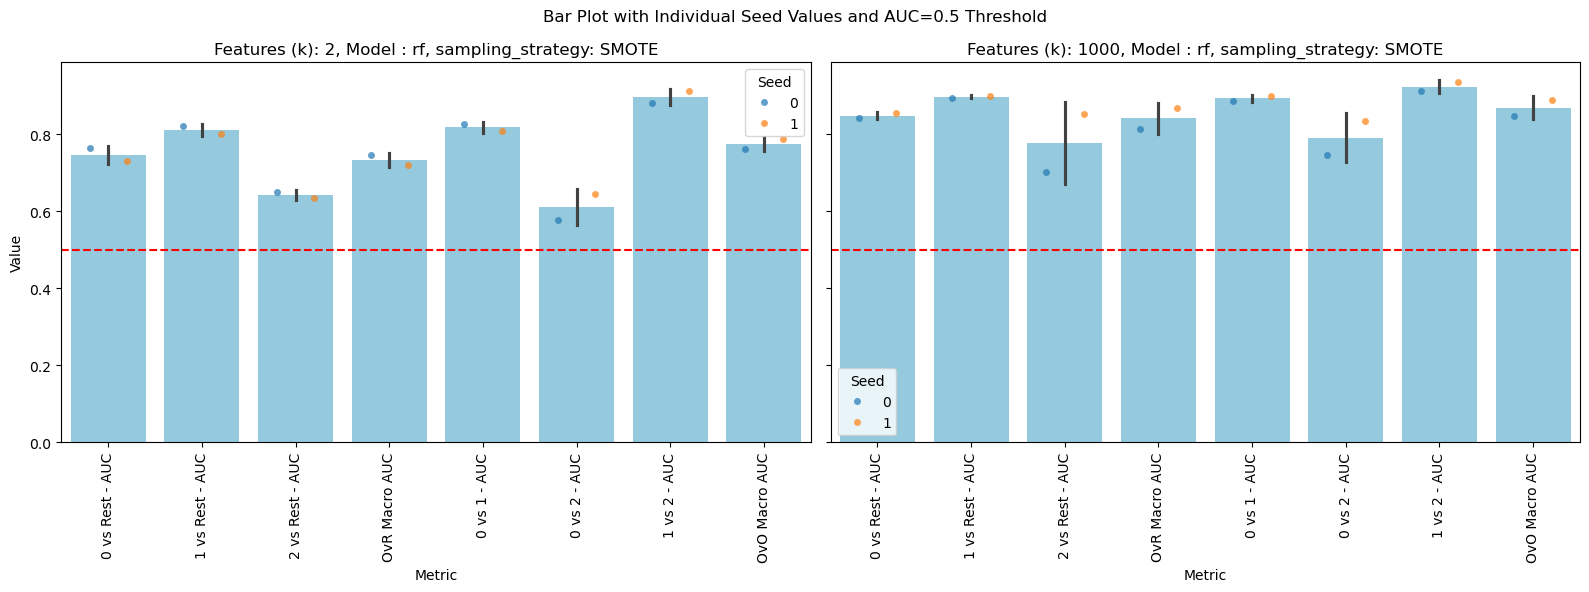

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_bar(output,ks,label,model,sampling_strategy):
    # Assuming `df` is your DataFrame
    df = pd.read_csv(output)
   
    # Resetting the index to simplify handling hierarchical index
    df = df.reset_index()
    
    # Filter the DataFrame to select only rows with required 'label' 
    df = df[(df['Label'] == label) & 
        (df['Model'] == model) & 
        (df['Sampling_Strategy'] == sampling_strategy)]


    #dropping columns as values irrelevant for metric
    df = df.drop(columns=['index','Unnamed: 0','Label','Model','Sampling_Strategy'], errors='ignore')
    #print(df)
    
    # Melting the dataframe to long format for seaborn compatibility
    df_melted = df.melt(
        id_vars=["Seed", "Features (k)"], 
        var_name="Metric", 
        value_name="Value"
    )
    df_melted = df_melted[df_melted["Metric"].str.contains("AUC", na=False)]

   

    print("\ndf_melted:\n",df_melted)
    
    # Create a new figure for each plot to prevent them from overlaying
    plt.figure(figsize=(16, 6))

    # Initialize the subplots
    fig, axes = plt.subplots(1, len(ks), figsize=(16, 6), sharey=True)
    
    # If only one subplot, make sure axes is iterable (a list of length 1)
    if len(ks) == 1:
        axes = [axes]
    
    # Iterate over the subsets ks
    for i, features in enumerate(ks):
        
        df_melted["Features (k)"] = df_melted["Features (k)"].astype(str)
        # Remove any quotes and strip spaces
        df_melted["Features (k)"] = df_melted["Features (k)"].str.replace(r"['\"]", "", regex=True)

        # Convert to numeric
        df_melted["Features (k)"] = pd.to_numeric(df_melted["Features (k)"], errors='coerce')
       
        subset = df_melted[df_melted["Features (k)"] == features]
        
        # Check if subset is empty
        if subset.empty:  
            print(f"Warning: No data for Features (k) = {features}")
            # Skip plotting for this subset
            continue  
    
        # Plot barplot for averages with error bars
        
        sns.barplot(
            data=subset, 
            x="Metric", 
            y="Value", 
            ax=axes[i], 
            ci="sd", 
            color="skyblue",
            estimator="mean",
           
        )
    
        # Overlay stripplot for individual seed values
        sns.stripplot(
            data=subset, 
            x="Metric", 
            y="Value", 
            ax=axes[i], 
            hue="Seed",
            dodge=True, 
            jitter=True, 
            alpha=0.7,
            
        )
    
        # Add a horizontal dashed red line for AUC = 0.5
        axes[i].axhline(0.5, color="red", linestyle="--", linewidth=1.5)
    
        # Set subplot title
        axes[i].set_title(f"Features (k): {features}, Model : {model}, sampling_strategy: {sampling_strategy}")
    
        # Rotate x-axis labels for clarity
        axes[i].tick_params(axis='x', rotation=90)
       
    
    
        
    # Set overall title and adjust layout
    fig.suptitle("Bar Plot with Individual Seed Values and AUC=0.5 Threshold")
    fig.tight_layout()
    plt.show()


plot_bar("benchmark/results/synthetic.csv",[2,1000],"s150_f1000_r200","rf","SMOTE")


#  Plot all k for all modes

   Seed  Features (k)  0 vs Rest - AUC  1 vs Rest - AUC  2 vs Rest - AUC  \
0     0             2         0.763386         0.822852         0.650998   
1     0          1000         0.841481         0.895094         0.702206   
2     1             2         0.730159         0.800488         0.633403   
3     1          1000         0.854815         0.900515         0.853992   

   0 vs Rest - Precision  0 vs Rest - Recall  0 vs Rest - F1  0 vs Rest - MCC  \
0               0.835052            0.771429        0.801980        -0.366214   
1               0.808000            0.961905        0.878261        -0.510559   
2               0.826087            0.723810        0.771574        -0.323247   
3               0.809524            0.971429        0.883117        -0.509648   

   1 vs Rest - Precision  ...  1 vs 2 - AUC  1 vs 2 - Precision  \
0               0.527778  ...      0.882488            0.642857   
1               0.760000  ...      0.912442            0.818182   
2           

/tmp/ipykernel_251225/3525803671.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab10", len(ovr_metrics))  # Tab10 colormap for 4 colors


<Figure size 1200x800 with 0 Axes>

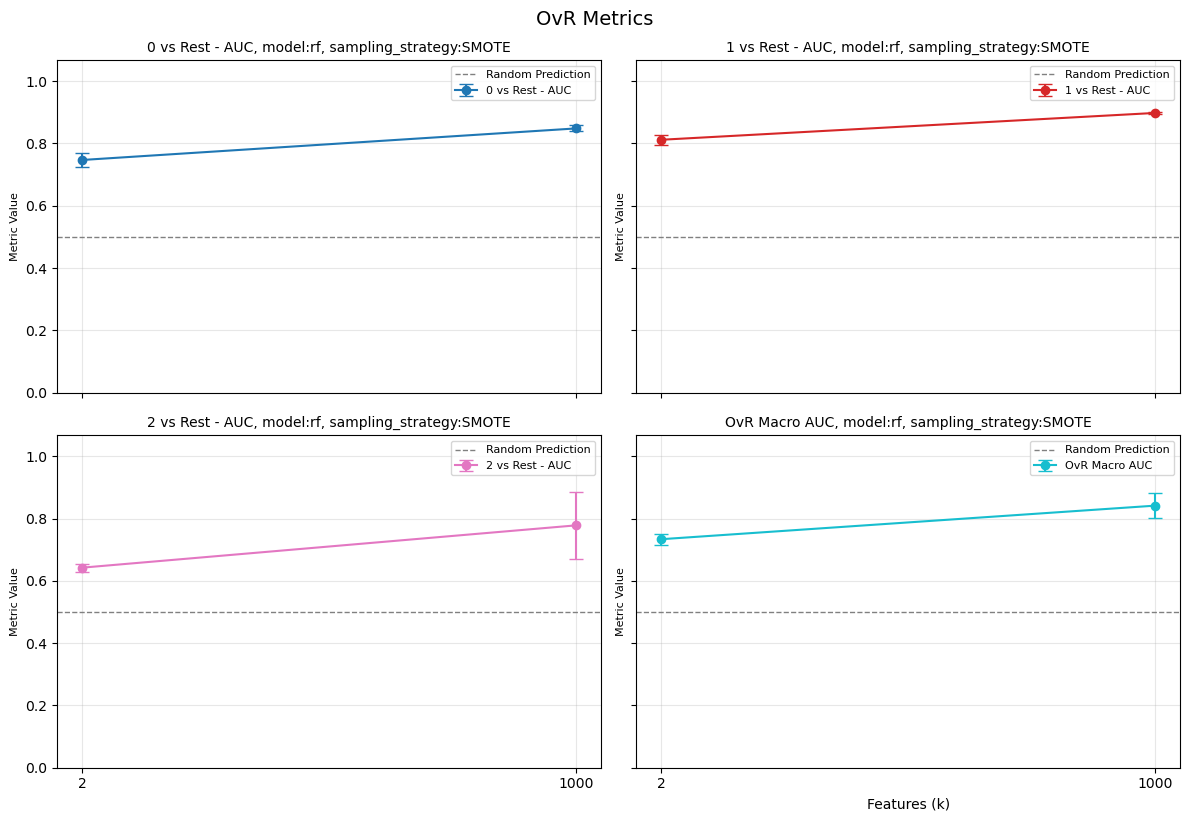

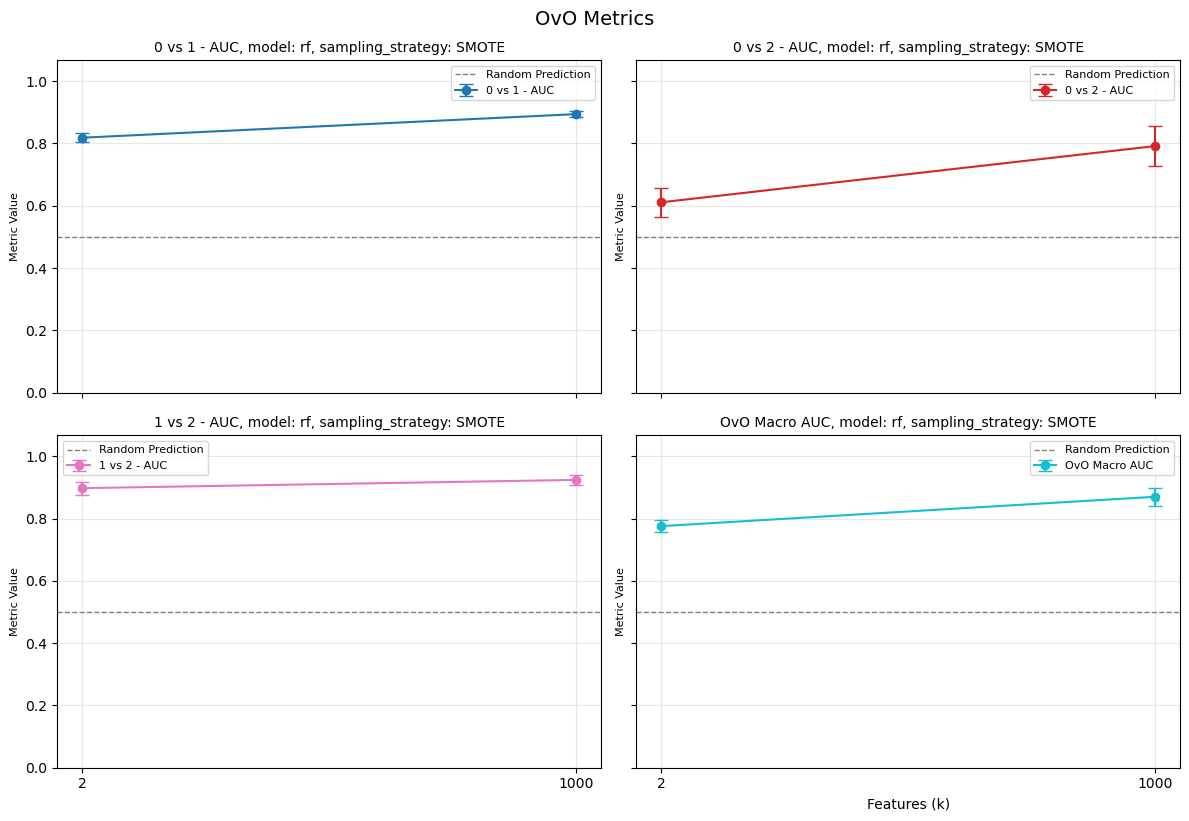

In [5]:
def plot_all_modes(output, label, model, sampling_strategy):
    df = pd.read_csv(output, index_col = 0)

    # Filter the DataFrame to select only rows with required 'label' 
    df = df[(df['Label'] == label) & 
        (df['Model'] == model) & 
        (df['Sampling_Strategy'] == sampling_strategy)]

    
    #converting features to str to remove unnecessary data
    df["Features (k)"] = df["Features (k)"].astype(str)
    
    # Remove any quotes and strip spaces
    df["Features (k)"] = df["Features (k)"].str.replace(r"['\"]", "", regex=True)

    #removing columns as irrelevant to metric
    df = df.drop(columns=['index','Unnamed: 0','Label','Model','Sampling_Strategy'], errors='ignore')
    
    # Convert to numeric
    df["Features (k)"] = pd.to_numeric(df["Features (k)"], errors='coerce')
    
    # Group by 'Features (k)' and calculate mean and std for each metric
    metrics = df.columns[5:]  # All numeric columns after sampling_strategy'
    summary = df.groupby("Features (k)").agg(["mean", "std"])
    
    # Map 'Features (k)' to evenly spaced indices
    features = summary.index
    x_indices = range(len(features))
    print(df)
    # Separate OvR and OvO metrics
    ovr_metrics = ["0 vs Rest - AUC","1 vs Rest - AUC","2 vs Rest - AUC", "OvR Macro AUC"]
    ovo_metrics = ["0 vs 1 - AUC","0 vs 2 - AUC","1 vs 2 - AUC", "OvO Macro AUC"]
    
    # Find the y-axis range for all metrics
    y_min = max(0, min(summary[(metric, "mean")].min() for metric in metrics) - 0.1)
    y_max = max(summary[(metric, "mean")].max() for metric in metrics) + 0.1
    
    # Generate a colormap
    color_map = cm.get_cmap("tab10", len(ovr_metrics))  # Tab10 colormap for 4 colors
    plt.figure(figsize=(12, 8))
    # Plot OvR metrics
   
    fig_ovr, axes_ovr = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes_ovr = axes_ovr.flatten()
    
    for i, (ax, metric) in enumerate(zip(axes_ovr, ovr_metrics)):
        means = summary[(metric, "mean")]
        stds = summary[(metric, "std")]
        ax.errorbar(
            x_indices,
            means,
            yerr=stds,
            capsize=5,
            marker="o",
            color=color_map(i),
            label=metric,
        )
        ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Random Prediction")
        ax.set_title(f"{metric}, model:{model}, sampling_strategy:{sampling_strategy}", fontsize=10)
        ax.set_ylabel("Metric Value", fontsize=8)
        ax.grid(alpha=0.3)
        ax.legend(loc="best", fontsize=8)
        ax.set_ylim(0, y_max)  # Apply the same y-axis range
    
    axes_ovr[-1].set_xticks(x_indices)
    axes_ovr[-1].set_xticklabels(features)
    axes_ovr[-1].set_xlabel("Features (k)", fontsize=10)
    
    plt.tight_layout()
    fig_ovr.suptitle("OvR Metrics", fontsize=14, y=1.02)
    plt.show()
    
    # Plot OvO metrics
    fig_ovo, axes_ovo = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes_ovo = axes_ovo.flatten()
    
    for i, (ax, metric) in enumerate(zip(axes_ovo, ovo_metrics)):
        means = summary[(metric, "mean")]
        stds = summary[(metric, "std")]
        ax.errorbar(
            x_indices,
            means,
            yerr=stds,
            capsize=5,
            marker="o",
            color=color_map(i),
            label=metric,
        )
        ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Random Prediction")
        ax.set_title(f"{metric}, model: {model}, sampling_strategy: {sampling_strategy}", fontsize=10)
        ax.set_ylabel("Metric Value", fontsize=8)
        ax.grid(alpha=0.3)
        ax.legend(loc="best", fontsize=8)
        ax.set_ylim(y_min, y_max)  # Apply the same y-axis range
    
    axes_ovo[-1].set_xticks(x_indices)
    axes_ovo[-1].set_xticklabels(features)
    axes_ovo[-1].set_xlabel("Features (k)", fontsize=10)
    
    plt.tight_layout()
    fig_ovo.suptitle("OvO Metrics", fontsize=14, y=1.02)
    plt.show()


plot_all_modes("benchmark/results/synthetic.csv","s150_f1000_r200","rf","SMOTE")

# Load HP multiomics data


In [4]:
# load the real data

X_raw_amplicon = pd.read_csv('input/HP_multiomics/Amplicon_X.csv', sep="\t", index_col=0)
X_raw_rna = pd.read_csv('input/HP_multiomics/RNA_X.csv', sep="\t", index_col=0)
y_raw = pd.read_csv('input/HP_multiomics/metadata.csv', sep = "\t", index_col=0)


In [6]:

index_intersect = y_raw.index.intersection(X_raw_amplicon.index)
index_intersect = X_raw_amplicon.index.intersection(X_raw_rna.index)

X_raw_amplicon = X_raw_amplicon.loc[index_intersect]
X_raw_rna = X_raw_rna.loc[index_intersect]

# sort index 
X_amplicon = X_raw_amplicon.sort_index()
X_rna = X_raw_rna.sort_index()
y_raw = y_raw.sort_index()

# Merge both features dfs
X_merge = pd.concat([X_amplicon, X_rna], axis=1)

print("X_amplicon shape: ", X_amplicon.shape)  
print("X_rna shape: ", X_rna.shape)
print("X_merge shape: ", X_merge.shape)
print("y_raw shape: ", y_raw.shape)

y = y_raw.loc[:,"Sample Condition"]


X_amplicon shape:  (132, 6228)
X_rna shape:  (132, 60839)
X_merge shape:  (132, 67067)
y_raw shape:  (132, 22)


# evaluating different models on real data


In [ ]:
import sys
import os
from sklearn.datasets import make_classification
import pandas as pd
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))  

from mcp.multiclasspredict import run_classification

n_seeds = 2
ks = [10]
result_path="benchmark/results/real.csv"
for model in ['rf', 'xgb', 'etc', 'lgbm']:
    print(f"model: {model} ")
    print("Amplicon scores:")
    run_classification(X_raw_amplicon, y, ks, n_seeds,result_path,"amplicon_16s", model, None)

    print("RNA scores")
    run_classification(X_raw_rna, y, ks, n_seeds,result_path,"rna_trans", model, None)

    print("Merged scores")
    run_classification(X_merge, y, ks, n_seeds,result_path,"merge", model, None)
    
    
    
    
            
'''run_classification(X_raw_amplicon, y, ks, n_seeds, "rf", None, os.path.join(result_path, f"rf_16s.csv"))
run_classification(X_raw_1, y, ks, n_seeds, "xgb", None, os.path.join(result_path, f"xgb_16s.csv"))
run_classification(X_raw_1, y, ks, n_seeds, "etc", None, os.path.join(result_path, f"etc_16s.csv"))
run_classification(X_raw_1, y, ks, n_seeds, "lgbm", None, os.path.join(result_path, f"lgbm_16s.csv"))

run_classification(X_raw_2, y, ks, n_seeds, "rf", None, os.path.join(result_path, f"rf_trans.csv"))
run_classification(X_raw_2, y, ks, n_seeds, "xgb", None, os.path.join(result_path, f"xgb_trans.csv"))
run_classification(X_raw_2, y, ks, n_seeds, "etc", None, os.path.join(result_path, f"etc_trans.csv"))
run_classification(X_raw_2, y, ks, n_seeds, "lgbm", None, os.path.join(result_path, f"lgbm_trans.csv"))

run_classification(X_raw, y, ks, n_seeds, "rf", None, os.path.join(result_path, f"rf_both.csv"))
run_classification(X_raw, y, ks, n_seeds, "xgb", None, os.path.join(result_path, f"xgb_both.csv"))
run_classification(X_raw, y, ks, n_seeds, "etc", None, os.path.join(result_path, f"etc_both.csv"))
run_classification(X_raw, y, ks, n_seeds, "lgbm", None, os.path.join(result_path, f"lgbm_both.csv"))'''


# plot

In [ ]:


import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box(file_path,x_axis):
    
    df = pd.read_csv(file_path)
    '''
    #following code irrelevant now as complete data stored in one csv file ie, results/real.csv
    # Initialize an empty list to store data
    data_list = []
    
    # Loop through files in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            
            # Extract model and dataset from filename
            parts = file.split("_")
            model = parts[0]  # e.g., etc, lgbm, rf, xgb
            dataset = parts[1].split(".")[0]  # e.g., 16s, trans
            
            # Read CSV file
            df = pd.read_csv(file_path)
            
            # Add model and dataset as new columns
            df["Model"] = model
            df["Dataset"] = dataset
            
            # Append to list
            data_list.append(df)
    
    # Combine all data into a single DataFrame
    combined_df = pd.concat(data_list, ignore_index=True)
    '''
    # Convert "Features (k)" to numeric
    df["Features (k)"] = pd.to_numeric(df["Features (k)"], errors="coerce")
    
    # Separate data based on number of features
    df_10_features = df[df["Features (k)"] == 10]
    df_all_features = df[df["Features (k)"] != 10]  # Assuming "all features" is any value other than 10
    
    # Set up plotting style
    sns.set_theme(style="whitegrid")
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot OvR Macro AUC for 10 features
    sns.boxplot(data=df_10_features, x=x_axis, y="OvR Macro AUC", hue="Label", ax=axes[0, 0])
    axes[0, 0].set_title("OvR Macro AUC (10 Features)")
    
    # Plot OvO Macro AUC for 10 features
    sns.boxplot(data=df_10_features, x=x_axis, y="OvO Macro AUC", hue="Label", ax=axes[0, 1])
    axes[0, 1].set_title("OvO Macro AUC (10 Features)")
    
    # Plot OvR Macro AUC for all features
    sns.boxplot(data=df_all_features, x=x_axis, y="OvR Macro AUC", hue="Label", ax=axes[1, 0])
    axes[1, 0].set_title("OvR Macro AUC (All Features)")
    
    # Plot OvO Macro AUC for all features
    sns.boxplot(data=df_all_features, x=x_axis, y="OvO Macro AUC", hue="Label", ax=axes[1, 1])
    axes[1, 1].set_title("OvO Macro AUC (All Features)")
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig("AUC_Comparison_10_vs_All_Features.png")
    plt.show()


plot_box("result/real.csv","Model")

# plotting classwise AUC score

In [ ]:


def classwise_auc_plot(file_path,x_axis):
    #read df
    df = pd.read_csv(file_path)
    
    # Convert "Features (k)" to numeric
    df["Features (k)"] = pd.to_numeric(df["Features (k)"], errors="coerce")
    
    # Separate data based on number of features
    df_10_features = df[df["Features (k)"] == 10]
    df_all_features = df[df["Features (k)"] != 10]  # Assuming "all features" means not 10
    
    # Define class-wise AUC columns
    class_auc_columns = [
        "Negative control vs Rest - AUC",
        "Patient vs Rest - AUC",
        "Positive control vs Rest - AUC",
        "Negative control vs Patient - AUC",
        "Negative control vs Positive control - AUC",
        "Patient vs Positive control - AUC"
    ]
    
    # Set up plotting style
    sns.set_theme(style="whitegrid")
    
    # --- PLOT OvR and OvO Macro AUC ---
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    '''
    # already done in  above code
    # Plot OvR Macro AUC for 10 features
    sns.boxplot(data=df_10_features, x="Model", y="OvR Macro AUC", hue="Label", ax=axes[0, 0])
    axes[0, 0].set_title("OvR Macro AUC (10 Features)")
    
    # Plot OvO Macro AUC for 10 features
    sns.boxplot(data=df_10_features, x="Model", y="OvO Macro AUC", hue="Label", ax=axes[0, 1])
    axes[0, 1].set_title("OvO Macro AUC (10 Features)")
    
    # Plot OvR Macro AUC for all features
    sns.boxplot(data=df_all_features, x="Model", y="OvR Macro AUC", hue="Label", ax=axes[1, 0])
    axes[1, 0].set_title("OvR Macro AUC (All Features)")
    
    # Plot OvO Macro AUC for all features
    sns.boxplot(data=df_all_features, x="Model", y="OvO Macro AUC", hue="Label", ax=axes[1, 1])
    axes[1, 1].set_title("OvO Macro AUC (All Features)")
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig("AUC_Comparison_10_vs_All_Features.png")
    plt.show()
    
    '''
    
    # --- PLOT CLASS-WISE AUCs ---
    for col in class_auc_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
        # Plot for 10 features
        sns.boxplot(data=df_10_features, x=x_axis, y=col, hue="Label", ax=axes[0])
        axes[0].set_title(f"{col} (10 Features)")
    
        # Plot for all features
        sns.boxplot(data=df_all_features, x=x_axis, y=col, hue="Label", ax=axes[1])
        axes[1].set_title(f"{col} (All Features)")
    
        # Adjust layout and save the figure
        plt.tight_layout()
        filename = col.replace(" ", "_").replace("-", "").replace("/", "_") + "_Comparison.png"
        plt.savefig(filename)
        plt.show()

classwise_auc_plot("result/real.csv","Model")

# Evaluate different sampling options 

In [ ]:

n_seeds = 2
ks = [10]
result_path="results/real.csv"
for sampling_strategy in ['No Sampling','Random OverSampling','SMOTE','Random UnderSampling','NearMiss (v1)','NearMiss (v2)','NearMiss (v3)']:
    print(f"model: rf ,\n sampling_strategy : {sampling_strategy}")
    run_classification(X_raw_amplicon, y, ks, n_seeds,result_path,"amplicon16s", "rf", sampling_strategy)
    run_classification(X_raw_rna, y, ks, n_seeds,result_path,"rna_trans", "rf", sampling_strategy)
    run_classification(X_merge, y, ks, n_seeds,result_path,"merge", "rf", sampling_strategy)

#plots
plot_box(result_path,"Sampling_Strategy")
classwise_auc_plot(result_path,"Sampling_Strategy")

